# <center> <img src="../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> **Big Data** </center>
---
### <center> **Autumn 2025** </center>
---
### <center> **Examples on Structured Streaming (files)** </center>
---
**Profesor**: Pablo Camarillo Ramirez

# Create SparkSession

In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on Structured Streaming") \
    .master("spark://spark-master:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

# Create a data stream from a local socket

### Install netcat utility

In [ ]:
!apt-get update
!apt-get install -y netcat

### Connect Spark to the socket

In [ ]:
# Create the remote connection
lines = spark.readStream \
            .format("socket") \
            .option("host", "localhost") \
            .option("port", 9999) \
            .load()
# Perform some transformations to the input data (word counter)
from pyspark.sql.functions import explode, split
words = lines.select(explode(split(lines.value, " ")).alias("word"))
word_count = words.groupBy("word").count()

# Send transformed data to the Sink
query = word_count.writeStream \
            .outputMode("complete") \
            .format("console") \
            .start()
query.awaitTermination(120)


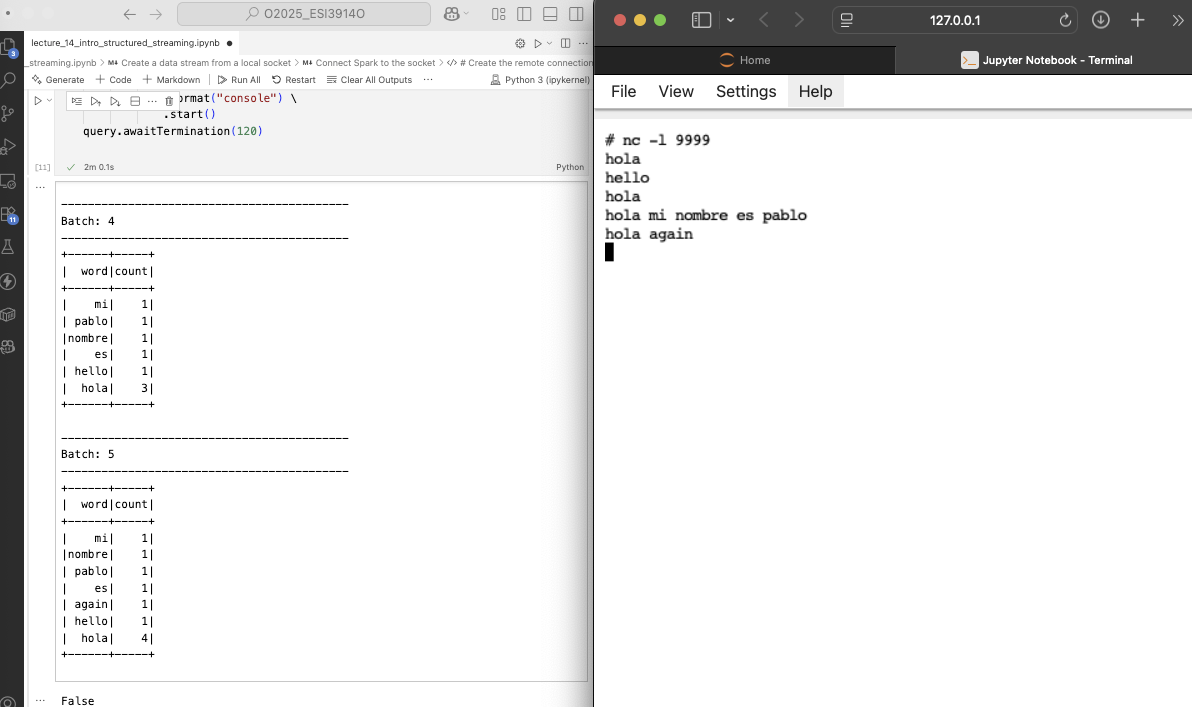

# Create a data stream from files

In [ ]:
!ls data/structured_streaming_names/


In [13]:
from pcamarillor.spark_utils import SparkUtils

names_schema = SparkUtils.generate_schema([("name", "string"), ("gpa", "float")])

names_df = spark.readStream \
            .schema(names_schema) \
            .format("json") \
            .load("/opt/spark/work-dir/data/structured_streaming_names/")

query = names_df.writeStream \
            .outputMode("append") \
            .format("console") \
            .start()
query.awaitTermination(120)

-------------------------------------------
Batch: 0
-------------------------------------------
+----------+----+
|      name| gpa|
+----------+----+
|   rodrigo|57.7|
|FranciscoD| 3.8|
|  Fernando| 3.6|
|   rodrigo|57.7|
|     pablo|45.3|
|     Mateo|49.9|
|     pablo|45.3|
|     Andre|67.5|
|     IvanE| 3.8|
|   Arantxa|50.0|
|    Daniel| 4.0|
|       Jos|43.2|
|    Renata|50.0|
+----------+----+

-------------------------------------------
Batch: 1
-------------------------------------------
+------+---+
|  name|gpa|
+------+---+
|Daniel|4.0|
+------+---+

-------------------------------------------
Batch: 7
-------------------------------------------
+------+---+
|  name|gpa|
+------+---+
|Daniel|4.0|
+------+---+

-------------------------------------------
Batch: 7
-------------------------------------------
+------+---+
|  name|gpa|
+------+---+
|Daniel|4.0|
+------+---+

-------------------------------------------
Batch: 9
-------------------------------------------
+------+--

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/opt/spark/python/lib/py4j-0.10.9.9-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/spark/python/lib/py4j-0.10.9.9-src.zip/py4j/clientserver.py", line 535, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [14]:
query.stop()
sc.stop()
